In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import glob
from PIL import Image
import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim
import torch.autograd as ag
from sklearn.model_selection import train_test_split

print(os.listdir("/datasets/ee285f-public/human-protein"))

['sample_submission.csv', 'train', 'test', 'train.csv']


In [35]:
from sklearn.metrics import f1_score
import scipy.optimize as opt

In [36]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))
    img = std * inp + mean
    return img

In [37]:
def plot_organelles(string,is_train = True, preds_test = [], preds_train = []):
    
    #X, y = next(iter(dset_loaders))
    #X, y = X.numpy(), y.numpy()
    
    loaded = np.load(string)
    inputs = loaded['a']
    #inputs = torch.from_numpy(inputs)
    labels = loaded['b']
    #labels = torch.from_numpy(labels)
    
    X,y = inputs, labels
    
    plt.figure(figsize=(20,10))
    for i in range(0, 4):
        plt.subplot(1,4,i+1)
        rand_img = random.randrange(0, X.shape[0])
        img = denormalize(X[rand_img,:,:,:])
        img = np.clip(img, 0, 1.0)    
        plt.imshow(img)
        plt.axis('off')

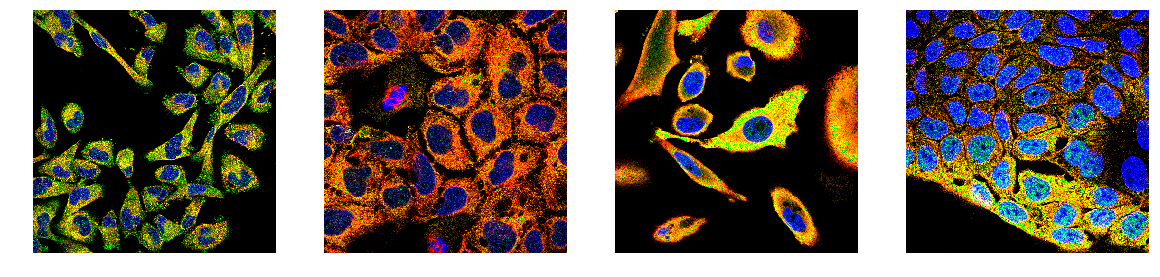

In [38]:
toplot = np.random.randint(100,130)
string = './TrainFolder/train'+ str(toplot) + '.npz'
plot_organelles(string)

In [39]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

In [40]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(28)
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [41]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [42]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [43]:
class MyDenseNetConv2(torch.nn.Module):
    def __init__(self, fixed_extractor = True):
        super(MyDenseNetConv2,self).__init__()
        original_model = torchvision.models.resnet18(pretrained=True)
        self.features = torch.nn.Sequential(*list(original_model.children())[:-3])
        
        if fixed_extractor:
            for param in self.parameters():
                param.requires_grad = True

    def forward(self, x):
        x = self.features(x)
        x = F.relu(x, inplace=True)
        #x = F.avg_pool2d(x, kernel_size=7).view(x.size(0), -1)
        return x

class MyDenseNetDens2(torch.nn.Module):
    def __init__(self, nb_out=28):
        super(MyDenseNetDens2,self).__init__()
        self.conv1 = torch.nn.Conv2d(256, 512, 5, stride = (2,2))
        self.conv1_bn = torch.nn.BatchNorm2d(512)
        self.dens1 = torch.nn.Linear(in_features=512, out_features=256)
        self.dens2 = torch.nn.Linear(in_features=256, out_features=128)
        self.dens3 = torch.nn.Linear(in_features=128, out_features=nb_out)
        
    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
        x = self.dens1(x)
        x = torch.nn.functional.selu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.dens2(x)
        x = torch.nn.functional.selu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.dens3(x)
       # x = F.sigmoid(self.dens3(x))
        
        return x

class MyDenseNet2(torch.nn.Module):
    def __init__(self):
        super(MyDenseNet2,self).__init__()
        self.mrnc = MyDenseNetConv2()
        self.mrnd = MyDenseNetDens2()
    def forward(self, x):
        x = self.mrnc(x)
        x = self.mrnd(x)
        return x 

In [44]:
model = MyDenseNet2()

In [45]:
#model.load_state_dict(torch.load('./every_sixth_model2'))
print model

MyDenseNet2(
  (mrnc): MyDenseNetConv2(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU(inplac

In [46]:
total_param= sum(p.numel() for p in model.parameters())
print total_param

6228956


In [47]:
use_gpu = torch.cuda.device_count() > 0
print("{} GPU's available:".format(torch.cuda.device_count()) )

1 GPU's available:


In [48]:
if use_gpu:
    print("Using all GPU's ")
    model = torch.nn.DataParallel(model)
    model.cuda()


Using all GPU's 


In [49]:
seq_array = np.arange(100,130)
seq_array_valtr = np.arange(100,112)

In [50]:
def train(criterion,optimizer, model,epochs=10):
    loss_array = []
    loss_array_valid = []
    best_loss = 2e10
    for epoch in range(epochs):
        
        print('Epoch {}/{}'.format(epoch, epochs - 1))

        running_loss =0.0 
        running_loss_valid = 0.0
        #ii_n_train = len(dset_loaders_train)
        start = time.time()
        iterate = list(np.random.permutation(seq_array))
        #print(len(iterate))
        #for i, (inputs, labels) in enumerate(dset_loaders_train):
        for cnt, i in enumerate (iterate):
            string = './TrainFolder/train'+ str(i) + '.npz'
            loaded = np.load(string)
            inputs = loaded['a']
            inputs = torch.from_numpy(inputs)
            labels = loaded['b']
            labels = torch.from_numpy(labels)
            if torch.cuda.is_available():
                inputs = ag.Variable(inputs.cuda(),requires_grad = True)
                labels = ag.Variable(labels.cuda(),requires_grad = False).float()


            optimizer.zero_grad()
            
            outputs = model.forward(inputs)
            
            loss = criterion(outputs, labels)
            del(outputs)
            del(inputs)
            del(labels)
            loss.backward()

            #Parameter Step
            optimizer.step()

            running_loss += loss[0]

            #loss_array  = []
            print('\rbatch: {}/{}'.format(cnt, 30))
            if (cnt%6 == 5):   
                #with torch.no_grad():                
                print('[%d ,%5d] loss : %.3f' %(epoch+1,cnt+1,running_loss/6)) #Printing average loss per minibatch summed over 6 mini batches
                loss_array.append(float(running_loss/6))
                running_loss = 0.0
                end = time.time()
                print(end-start)
                start = time.time()
                 
                torch.save(model.state_dict(), './every_sixth_model2')
                #if (cnt%101 == 100 or cnt == 583):
                #for j, (inputs_valid, labels_valid) in enumerate(dset_loaders_valid):
                for j in seq_array_valtr:
                    #print(j)
                    string = './ValidFolder/valid'+ str(j) + '.npz'
                    loaded = np.load(string)
                    inputs_valid = loaded['a']
                    inputs_valid = torch.from_numpy(inputs_valid)
                    labels_valid = loaded['b']
                    labels_valid = torch.from_numpy(labels_valid)
                    if torch.cuda.is_available():
                        inputs_valid = ag.Variable(inputs_valid.cuda(),requires_grad = False, volatile=True)
                        labels_valid = ag.Variable(labels_valid.cuda(),requires_grad = False, volatile=True).float()
                        #optimizer.zero_grad()
                    model = model.eval()
                    outputs_valid = model.forward(inputs_valid)
                    loss_valid = criterion(outputs_valid, labels_valid)
                    del inputs_valid
                    del labels_valid
                    del outputs_valid
                    running_loss_valid += loss_valid.data[0]
                if running_loss_valid/12.0 < best_loss:
                    best_loss = running_loss_valid/12.0
                    torch.save(model.state_dict(), './best_model2')
                    print('best loss : %.3f' %(best_loss))
                #else: 
                    #model.load_state_dict(torch.load('./best_model2'))
                model = model.train()
                print('valid loss : %.3f' %(running_loss_valid/ 12.0))
                loss_array_valid.append(float(running_loss_valid/12.0))
                running_loss_valid = 0.0
    print('Finished Training!')
    return loss_array, loss_array_valid

In [51]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss,self).__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [52]:
gamma = 0.05
rho = 0.9
criterion = FocalLoss()
optimizer = torch.optim.SGD(model.module.parameters(),lr=gamma, momentum = rho)

In [53]:
print model

DataParallel(
  (module): MyDenseNet2(
    (mrnc): MyDenseNetConv2(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (2): ReLU(inplace)
        (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
            (relu): ReLU(inplace)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-

In [54]:
loss_train_array, loss_valid_array = train(criterion,optimizer,model,1)

Epoch 0/0
batch: 0/30
batch: 1/30
batch: 2/30
batch: 3/30
batch: 4/30
batch: 5/30
[1 ,    6] loss : 2.626
2.80712509155
best loss : 1.485
valid loss : 1.485
batch: 6/30
batch: 7/30
batch: 8/30
batch: 9/30
batch: 10/30
batch: 11/30
[1 ,   12] loss : 2.474
7.81519389153
best loss : 1.430
valid loss : 1.430
batch: 12/30
batch: 13/30
batch: 14/30
batch: 15/30
batch: 16/30
batch: 17/30
[1 ,   18] loss : 2.179
9.84422111511
valid loss : 2.308
batch: 18/30
batch: 19/30
batch: 20/30
batch: 21/30
batch: 22/30
batch: 23/30
[1 ,   24] loss : 2.203
9.93762898445
valid loss : 1.954
batch: 24/30
batch: 25/30
batch: 26/30
batch: 27/30
batch: 28/30
batch: 29/30
[1 ,   30] loss : 1.689
9.93759512901
valid loss : 1.706
Finished Training!


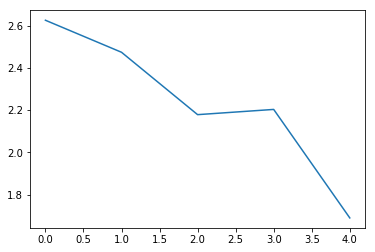

In [55]:
plt.plot(loss_train_array)

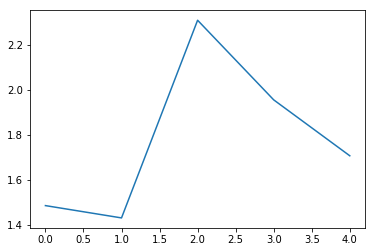

In [56]:
plt.plot(loss_valid_array)

In [57]:
#to compute F1 score for test data
preds_arr= np.zeros((32*12,28))
labels_arr= np.zeros((32*12,28))
model = model.eval()
start=time.time()
#new_arr = np.zeros((195*32,3,512,512))
#new_arr = np.zeros((195*32,28))
for cnt,i in enumerate(seq_array_valtr):
    string = './TestFolder/test'+ str(i) + '.npz'
    loaded = np.load(string)
    inputs = loaded['a']
    labels = loaded['b']
    inputs = torch.from_numpy(inputs)
    #labels = torch.from_numpy(labels)
    inputs = ag.Variable(inputs.cuda(),requires_grad = True)
    #labels = ag.Variable(labels.cuda(),requires_grad = False).float()
    preds = model(inputs)
    preds = preds.cpu()
    preds = preds.data.numpy()
    
    #labels = labels.numpy()
    #labels = labels.cpu()
    #preds = np.stack(preds, axis=-1)
    preds = sigmoid_np(preds)
    preds_arr[cnt*32:(cnt+1)*32,:] = preds
    labels_arr[cnt*32:(cnt+1)*32,:] = labels
    #preds = preds.max(axis=-1)
    #print(preds.shape)
    #print(labels.shape) 


In [59]:
train_seq_array_valtr = np.arange(100,130)

In [60]:
#to compute F1 score for train data
preds_arr= np.zeros((32*30,28))
labels_arr= np.zeros((32*30,28))
model = model.eval()
start=time.time()
#new_arr = np.zeros((195*32,3,512,512))
#new_arr = np.zeros((195*32,28))
for cnt,i in enumerate(train_seq_array_valtr):
    string = './TrainFolder/train'+ str(i) + '.npz'
    loaded = np.load(string)
    inputs = loaded['a']
    labels = loaded['b']
    inputs = torch.from_numpy(inputs)
    #labels = torch.from_numpy(labels)
    inputs = ag.Variable(inputs.cuda(),requires_grad = True)
    #labels = ag.Variable(labels.cuda(),requires_grad = False).float()
    preds = model(inputs)
    preds = preds.cpu()
    preds = preds.data.numpy()
    
    #labels = labels.numpy()
    #labels = labels.cpu()
    #preds = np.stack(preds, axis=-1)
    preds = sigmoid_np(preds)
    preds_arr[cnt*32:(cnt+1)*32,:] = preds
    labels_arr[cnt*32:(cnt+1)*32,:] = labels
    #preds = preds.max(axis=-1)
    #print(preds.shape)
    #print(labels.shape) 

In [62]:
    print('F1 macro (th = 0.5): ',f1_score(labels_arr, preds_arr>0.5, average='macro'))
    th = fit_val(preds,labels)
    th[th<0.1] = 0.1
    print('Thresholds: ',th)
    print('F1 macro: ',f1_score(labels_arr, preds_arr>th, average='macro'))   #final F1 score
    #print('F1 macro (th = 0.5): ',f1_score(labels, preds>0.5, average='macro'))
    #print('F1 micro: ',f1_score(labels, preds>th, average='micro'))
    #print(outputs_test.shape)
    
    end=time.time()
    print(end-start)

('F1 macro (th = 0.5): ', 0.004859086491739552)
('Thresholds: ', array([0.1, 0.1, 0.1, 0.5, 0.1, 0.1, 0.1, 0.5, 0.5, 0.5, 0.5, 0.1, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.1, 0.1, 0.5, 0.1,
       0.5, 0.5]))
('F1 macro: ', 0.077581285440952)
31.9610998631
